In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import piv_fun as piv
import pof_piv as piv_old
import cv2 as cv

In [2]:
%load_ext autoreload
%autoreload 2

In [38]:
np.rad2deg(np.pi/4)

45.0

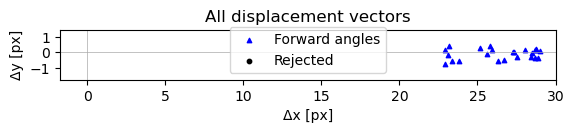

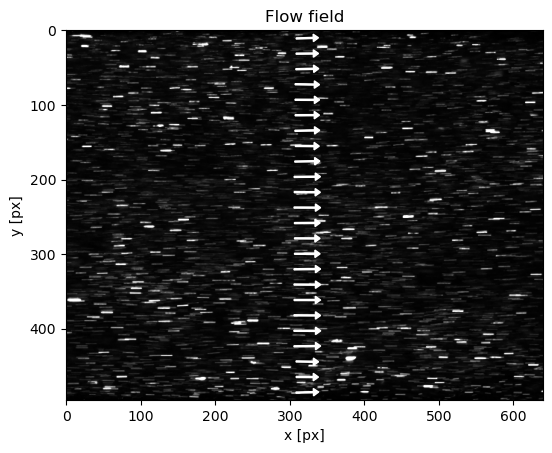

26.446733418479653


In [66]:
# window_counts = (25, 8)
nr_position = 4
nr_series = 4
directory = 'piv_examples/pos' + str(nr_position) + '-' + str(nr_series) + '/'

margins = [[48, 496-443, 0, 0], 
           [60, 496-452, 0, 0],
           [10, 496-480, 0, 0],
           [0, 0, 128, 0]]
margins = margins[nr_position - 1]

frame_rate = 40000
max_shift_px = 100
hor_slices = 8
window_ct = (3, 32)
sum_rows = True
plot_flow_field = True
valid_angles = [np.pi / 4, 3 * np.pi / 4]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Check whether the width of the image is divisible by the number of windows
if (images.shape[2] - margins[2] - margins[3]) % window_ct[1] != 0:
    raise ValueError('Image width is not divisible by the number of windows')

# Subtract background
background = cv.imread('data/backgrounds/pos' + str(nr_position) + '-' + str(nr_series) + '.tif',
                       cv.IMREAD_GRAYSCALE)
images = piv.subtract_background(images, background=background)

# Cut off a number of pixels in each direction given by margins
images_crop = images[:, margins[0]:(images.shape[1] - margins[1]),
         margins[2]:(images.shape[2] - margins[3])]

# In the cropped images, calculate the center of each window
window_size = (images_crop[0].shape / 
               np.array([window_ct[0] * hor_slices, window_ct[1]]))
window_y = np.arange(window_size[0]/2, images_crop[0].shape[0], window_size[0])
window_x = np.arange(window_size[1]/2, images_crop[0].shape[1], window_size[1])\
    if not sum_rows else [images_crop[0].shape[1] / 2]
window_centers = np.array([[[y, x] for x in window_x] for y in window_y]) 

## FIRST PASS
corr_init = sig.correlate(images_crop[1], images_crop[0])
hor_disp_init = piv.displacement_1d(corr_init, max_disp=max_shift_px, plot=False)

# If the correlation map has no peak, there is no need to continue
if hor_disp_init == np.nan:
    print('No movement detected')
    
# If there is movement, shift the second image to match the first
images_shift = piv.shift_displaced_image(images_crop, hor_disp_init)

# SECOND PASS
# Divide the image into slices
slice_set = np.array_split(images_shift, hor_slices, axis=1)
disps = np.empty((window_ct[0] * hor_slices, window_ct[1], 2), dtype=np.float64) if not sum_rows else np.empty((window_ct[0] * hor_slices, 1, 2), dtype=np.float64)
disps[:] = np.nan

# Get the horizontal displacement in the slices
for j, slices in enumerate(slice_set):
    
    # Maximum displacement will be limited further,
    # with a minimum of 10 for peak detection purposes
    max_disp = hor_disp_init + 5 if hor_disp_init > 5 else 10
    # max_disp = max_disp
    
    # If the initial displacement was larger than 2 px, we will prevent the 
    # next search from flipping back onto the original peak at 0 movement
    ignore_only_if_mult = False if hor_disp_init > 2 else True
    
    # Calculate the displacement in the slice
    corr_slice = sig.correlate(slices[1], slices[0])
    hor_disp_slice = piv.displacement_1d(corr_slice, 
                                         ignore_disp=-hor_disp_init, 
                                         ignore_only_if_mult=ignore_only_if_mult,
                                         max_disp=max_disp,
                                         plot=False)
    
    # If this gives no result, there is no movement in this slice
    if np.isnan(hor_disp_slice):
        continue

    # Shift the second slice to match the first
    slices_shift = piv.shift_displaced_image(slices, hor_disp_slice)

    # THIRD PASS
    # Divide the slice into windows
    window_set = np.array_split(slices_shift, window_ct[0], axis=1)
    window_set = [np.array_split(row, window_ct[1], axis=2) for row in window_set]

    # For each window, calculate the correlation maps
    corr_set = [[sig.correlate(window[1], window[0]) for window in row] for row in window_set]

    if sum_rows:
        # Sum the correlation windows along the rows
        corr_set = [np.sum(row, axis=0, keepdims=True) for row in corr_set]
    
    # Calculate the displacement from the 2d correlation maps
    disp_set = [[piv.displacement_2d(corr, max_disp=max_disp) for corr in row] for row in corr_set]
        
    # Put the displacements in the correct place in the array
    for ji, row in enumerate(disp_set):
        for k, disp in enumerate(row):
            disps[ji + j * window_ct[0], k] = disp + [0, hor_disp_slice + hor_disp_init]

# Plot the displacement vectors           
_,_ = piv.plot_displacements(disps, highlight_radius_range = [1e-20, np.inf], highlight_angle_range=valid_angles, legend=['Forward angles', 'Rejected'])

# If the average horizontal displacement is larger than 1 px, 
# also replace displacements not in the valid angle range
if np.abs(np.nanmean(disps[:, :, 1])) > 1:
    valid_mask = piv.filter_displacements(disps, angle_range=valid_angles, 
                                          radius_range=[1, np.inf])
    disps[~valid_mask] = np.nan

# Plot flow field
if plot_flow_field:
    _, _ = piv.plot_flow_field(disps, window_centers, arrow_scale=1, arrow_color='white', background=images_crop[0])

# print(np.nanmean(np.linalg.norm(disps, axis=2), axis=1, keepdims=True))

if not np.all(np.isnan(disps[:,:,1])):
    print(np.nanmean(disps[:,:,1]))

# TODO: Maybe remove points that do not match their neighbours

np

In [10]:
np.linalg.norm(disps, axis=2)

array([[ 0.84756955, 13.98932065,  1.14367945,  4.84215909,  1.68777239,
         2.69305469, 14.05898278,  2.88570951, 14.16345946, 14.01993055,
         3.30051067,  3.27543857, 13.83746515,  2.26596056,  3.34198191,
         2.18350764, 13.81752646,  1.73537026, 14.17894972,  4.12186722,
         3.20912687,  4.25818699,  3.0469384 ,  1.14290537,  3.04336094,
         3.31519659,  2.87542371, 13.95311838,  3.57391923,  2.38523576,
        14.05547601, 14.10072042],
       [ 3.71257202, 13.97819299,  1.41262651, 14.05479308,  2.13802872,
        13.84748318,  3.82494221,  3.22004217,  3.35197521,  8.21925981,
         3.46292103,  3.48374864, 13.96855736,  4.13332793,  1.05557957,
        14.08446258,  2.82453865,  2.66951352,  6.34822655,  2.18536895,
         1.58876797,  3.01093855,  2.69939944, 13.97334058,  4.19690322,
         3.04444847,  5.59538365, 14.09964874,  5.16284933,  2.73569149,
         3.35354593, 14.23482625],
       [ 1.10765984, 14.21749623,  4.17236383,  3.2486